# Setup Pretrained Model

In [42]:
import torch
import torchvision.models as models
import torchvision.transforms as T
import os
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

resnet18 = models.resnet18(pretrained=True)

# set model to evaluation mode
resnet18.eval()
# Don't train model
for param in resnet18.parameters():
    param.requires_grad = False
resnet34 = models.resnet34(pretrained=True)
# set model to evaluation mode
resnet34.eval()
# Don't train model
for param in resnet34.parameters():
    param.requires_grad = False

resnet50 = models.resnet50(pretrained=True)
# set model to evaluation mode
resnet50.eval()
# Don't train model
for param in resnet50.parameters():
    param.requires_grad = False

resnet101 = models.resnet101(pretrained=True)
# set model to evaluation mode
resnet101.eval()
# Don't train model
for param in resnet101.parameters():
    param.requires_grad = False
    
resnet152 = models.resnet101(pretrained=True)
# set model to evaluation mode
resnet152.eval()
# Don't train model
for param in resnet152.parameters():
    param.requires_grad = False

vgg16 = models.vgg16(pretrained=True)
vgg16.eval()

for param in vgg16.parameters():
    param.requires_grad = False

inception = models.inception_v3(pretrained=True)
inception.eval()
for param in inception.parameters():
    param.requires_grad = False
    
squeezenet = models.squeezenet1_0()
squeezenet.eval()
for param in squeezenet.parameters():
    param.requires_grad = False

# These scripts are used for transforming the original image data
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize((size, size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=([1.0 / 0.229, 1.0 / 0.224, 1.0 / 0.225])),
        T.Normalize(mean=([-0.485, -0.456, -0.406]), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

# Load some Imagenet Images and helper functions

In [43]:
# Load some validation images (credit to cs231)
def load_images(num=None):
    """Load some Imagenet images.
    Inputs:
    - num: Number of images to load (max of 25)
    Returns:
    - X: numpy array with shape [num, 224, 224, 3]
    - y: numpy array of integer image labels, shape [num]
    - class_names: dict mapping integer label to class name
    """
    imagenet_fn = 'datasets/imagenet_val_25.npz'
    if not os.path.isfile(imagenet_fn):
      print('file %s not found' % imagenet_fn)
      print('Run the following:')
      print('cd datasets')
      print('bash get_imagenet_val.sh')
      assert False, 'Need to download imagenet_val_25.npz'
    f = np.load(imagenet_fn)
    X = f['X']
    y = f['y']
    class_names = f['label_map'].item()
    if num is not None:
        X = X[:num]
        y = y[:num]
    return X, y, class_names

In [60]:
X, y, class_names = load_images(1)
N = y.shape[0]

# Visualize Validation images with confidence

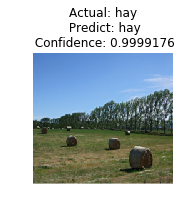

In [61]:
# Convert X inputs to a tensor
X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
# Then wrape tensor into a Variable
X_original = Variable(X_tensor.clone(), requires_grad=False)

scores = resnet18(X_original)
# Compute softmax
probs = torch.softmax(scores, dim=1)
output_scores, output_class_indexes = probs.max(dim=1, keepdim=False)


for i in range(N):
    subplot = plt.subplot(10, 5, i + 1)
    plt.imshow(X[i])
    title = "Actual: " + class_names[y[i]] 
    title += "\n Predict: " + class_names[output_class_indexes.numpy()[i]]
    # add score
    title += "\n Confidence: " + str(output_scores.detach().numpy()[i])
    plt.title(title)
    plt.axis('off')
    fig = plt.gcf()
plt.subplots_adjust(left  = 0.125, right = 0.9, bottom=0.2, top = 0.9, wspace = 0.2, hspace = 0.9)
fig.set_size_inches(20, 50)

# Non-targetted
We can distort by minimizing the score for the actual target class

In [62]:
# Wrap our data in another variable that tracks gradients
dtype = torch.FloatTensor
X_adversarial = Variable(X_tensor.clone(), requires_grad=True)
y_var = Variable(torch.LongTensor(y), requires_grad=False)
iterations = 10
epsilon = 0.5
for i in range(iterations):
    # compute scores with our adversarial images (currently the original data)
    adversarial_scores = resnet18(X_adversarial.clone())

    # Get unnormalized probabilities
    target_scores = adversarial_scores.gather(1, y_var.view(-1, 1)).squeeze()

    # now we back propogate to our original image
    target_scores.backward(torch.ones((N,),dtype=torch.float32).type(dtype))

    # implement fast gradient
    noise = X_adversarial.grad.clone()
    noise[noise < 0] = -1
    noise[noise > 0] = 1
   
    # Then multiplyig by noise
    dX = (epsilon/iterations * noise)

    # Now we do gradient ascent
    X_adversarial.data -= dX.data

    # Manually zero the gradients after updating weights
    X_adversarial.grad.zero_()
    print(i + 1)

1
2
3
4
5
6
7
8
9
10


# Visualize Untargeted

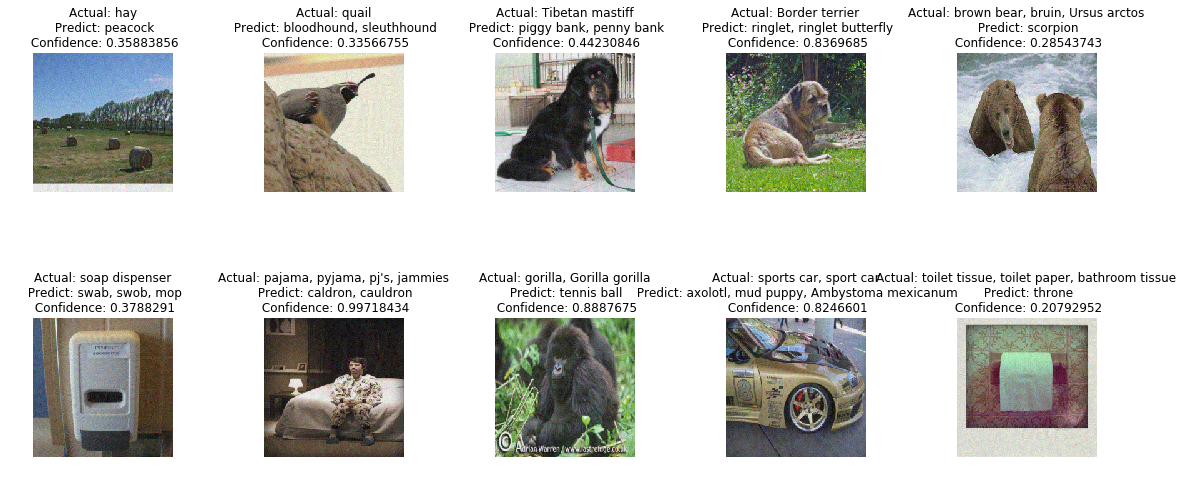

In [47]:
scores = resnet18(X_adversarial.clone())

# Compute softmax
probs = torch.softmax(scores, dim=1)
new_output_scores, new_output_class_indexes = probs.max(dim=1, keepdim=False)

for i in range(N):
    plt.subplot(10, 5, i + 1)
    plt.imshow(deprocess(X_adversarial[i].clone().view(-1,3,224,224)))
    title = "Actual: " + class_names[y[i]] 
    title += "\n Predict: " + class_names[new_output_class_indexes.numpy()[i]]
    # add score
    title += "\n Confidence: " + str(new_output_scores.detach().numpy()[i])
    plt.title(title)
    plt.axis('off')
    fig = plt.gcf()
plt.subplots_adjust(left  = 0.125, right = 0.9, bottom=0.2, top = 0.9, wspace = 0.2, hspace = 0.9)
fig.set_size_inches(20, 50)

# Transferability

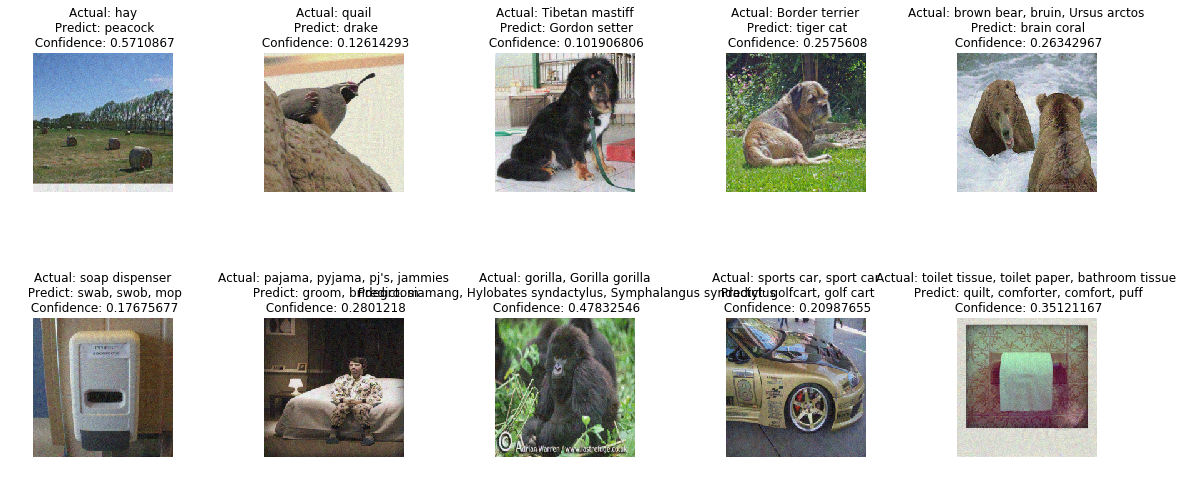

In [48]:
scores = vgg16(X_adversarial.clone())

probs = torch.softmax(scores, dim=1)
new_output_scores, new_output_class_indexes = probs.max(dim=1, keepdim=False)
plt.clf()

for i in range(N):
    plt.subplot(10, 5, i + 1)
    plt.imshow(deprocess(X_adversarial[i].clone().view(-1,3,224,224)))
    title = "Actual: " + class_names[y[i]] 
    title += "\n Predict: " + class_names[new_output_class_indexes.numpy()[i]]
    # add score
    title += "\n Confidence: " + str(new_output_scores.detach().numpy()[i])
    plt.title(title)
    plt.axis('off')
    fig = plt.gcf()
plt.subplots_adjust(left  = 0.125, right = 0.9, bottom=0.2, top = 0.9, wspace = 0.2, hspace = 0.9)
fig.set_size_inches(20, 50)

# Targetted Attack

Pick a number from 1-1000 for a target class

In [103]:
target_y = 15
# wrap target_y into a tensor Variable
target_y_var = Variable(torch.LongTensor([target_y]), requires_grad=False)
# print out selected class
print(class_names[target_y])

robin, American robin, Turdus migratorius


# Now we will apply fast gradient distortion based on the output of our dataset with epsilon = 1e-1

In [50]:
# Wrap our data in another variable that tracks gradients
dtype = torch.FloatTensor

X_adversarial = Variable(X_tensor.clone(), requires_grad=True)

iterations = 10
epsilon = 0.1
for i in range(iterations):
    # compute scores with our adversarial images (currently the original data)
    adversarial_scores = resnet18(X_adversarial)

    # Get unnormalized probabilities
    target_scores = adversarial_scores[:,target_y]

    # now we back propogate to our original image
    target_scores.backward(torch.ones((N,),dtype=torch.float32))

    # implement fast gradient
    noise = X_adversarial.grad.clone()
    noise[noise < 0] = -1
    noise[noise > 0] = 1
    # Then multiplyig by noise
    dX = (epsilon/iterations * noise)

    # Now we do gradient ascent
    X_adversarial.data += dX.data

    # Manually zero the gradients after updating weights
    X_adversarial.grad.zero_()
    print(i + 1)

1
2
3
4
5
6
7
8
9
10


# Now we re-visualize

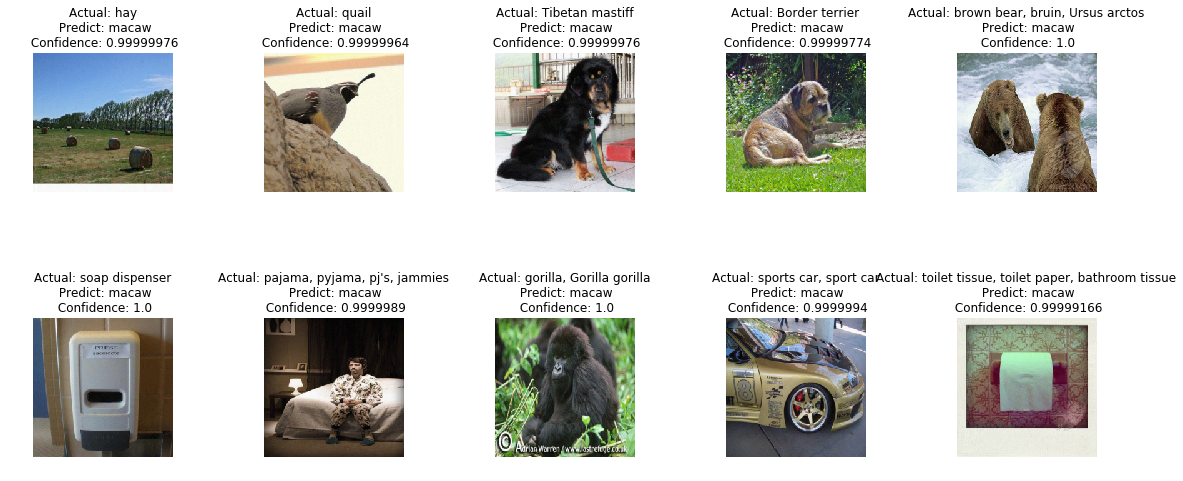

In [51]:
scores = resnet18(X_adversarial.clone())

# Compute softmax
probs = torch.softmax(scores, dim=1)
new_output_scores, new_output_class_indexes = probs.max(dim=1, keepdim=False)

for i in range(N):
    plt.subplot(10, 5, i + 1)
    plt.imshow(deprocess(X_adversarial[i].clone().view(-1,3,224,224)))
    title = "Actual: " + class_names[y[i]] 
    title += "\n Predict: " + class_names[new_output_class_indexes.numpy()[i]]
    # add score
    title += "\n Confidence: " + str(new_output_scores.detach().numpy()[i])
    plt.title(title)
    plt.axis('off')
    fig = plt.gcf()
plt.subplots_adjust(left  = 0.125, right = 0.9, bottom=0.2, top = 0.9, wspace = 0.2, hspace = 0.9)
fig.set_size_inches(20, 50)

# Try to trick with targetted attack...

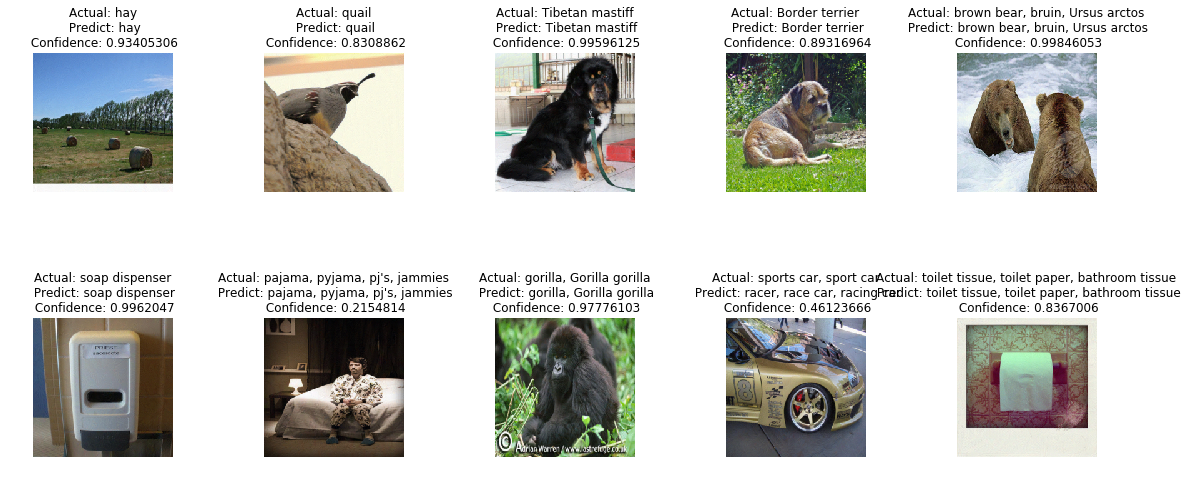

In [52]:
scores = vgg16(X_adversarial.clone())

# Compute softmax

probs = torch.softmax(scores, dim=1)
new_output_scores, new_output_class_indexes = probs.max(dim=1, keepdim=False)
plt.clf()

for i in range(N):
    plt.subplot(10, 5, i + 1)
    plt.imshow(deprocess(X_adversarial[i].clone().view(-1,3,224,224)))
    title = "Actual: " + class_names[y[i]] 
    title += "\n Predict: " + class_names[new_output_class_indexes.numpy()[i]]
    # add score
    title += "\n Confidence: " + str(new_output_scores.detach().numpy()[i])
    plt.title(title)
    plt.axis('off')
    fig = plt.gcf()
plt.subplots_adjust(left  = 0.125, right = 0.9, bottom=0.2, top = 0.9, wspace = 0.2, hspace = 0.9)
fig.set_size_inches(20, 50)

# Ensemble Attack!

In [104]:
# Wrap our data in another variable that tracks gradients
dtype = torch.FloatTensor
#dtype = torch.cuda.FloatTensor

X_adversarial = Variable(X_tensor.clone(), requires_grad=True)

def compute_gradient_noise(model, input_var):    
    adversarial_scores_1 = model(input_var)

    # Get unnormalized probabilities
    target_scores = adversarial_scores_1[:,target_y]

    # now we back propogate to our original image
    target_scores.backward(torch.ones((N,),dtype=torch.float32).type(dtype))

    # implement fast gradient
    noise = input_var.grad.clone()
    dX = (noise)
    
    input_var.grad.zero_()
    return dX

iterations = 10
epsilon = 0.1
for i in range(iterations):
    # compute scores with our adversarial images (currently the original data)
    dX = compute_gradient_noise(resnet34, X_adversarial)
    dX += compute_gradient_noise(resnet101, X_adversarial)
    dX += compute_gradient_noise(resnet152, X_adversarial)
    dX += compute_gradient_noise(resnet50, X_adversarial)
    dX += compute_gradient_noise(resnet18, X_adversarial)

    # Normalize dX
    dX[dX < 0] = -1
    dX[dX > 0] = 1
    # Scale by epsilon/iterations
    dX *= (epsilon)
    
    # Now we do gradient ascent
    X_adversarial.data += dX.data
    
    if i % 5 == 0:
        print(i + 1)

1
6


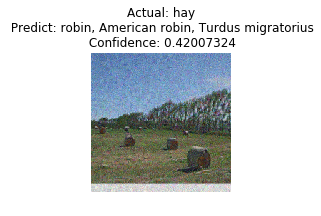

In [105]:
scores = vgg16(X_adversarial.clone())

# Compute softmax

probs = torch.softmax(scores, dim=1)
new_output_scores, new_output_class_indexes = probs.max(dim=1, keepdim=False)
plt.clf()

for i in range(N):
    plt.subplot(10, 5, i + 1)
    plt.imshow(deprocess(X_adversarial[i].clone().view(-1,3,224,224)))
    title = "Actual: " + class_names[y[i]] 
    title += "\n Predict: " + class_names[new_output_class_indexes.numpy()[i]]
    # add score
    title += "\n Confidence: " + str(new_output_scores.detach().numpy()[i])
    plt.title(title)
    plt.axis('off')
    fig = plt.gcf()
plt.subplots_adjust(left  = 0.125, right = 0.9, bottom=0.2, top = 0.9, wspace = 0.2, hspace = 0.9)
fig.set_size_inches(20, 50)